In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.postgresql:postgresql:42.2.5 pyspark-shell'

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder \
    .appName("AppName") \
    .config("spark.driver.memory", "64g") \
    .getOrCreate()

23/12/12 11:36:33 WARN Utils: Your hostname, localhost.localdomain resolves to a loopback address: 127.0.0.1; using 192.168.3.15 instead (on interface enp5s0)
23/12/12 11:36:33 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


:: loading settings :: url = jar:file:/data/projetos/datalakeBnafar/.venv/lib/python3.9/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /home/jesse/.ivy2/cache
The jars for the packages stored in: /home/jesse/.ivy2/jars
org.postgresql#postgresql added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-87a91da0-3713-4efc-bb04-4a83f5d71618;1.0
	confs: [default]
	found org.postgresql#postgresql;42.2.5 in central
:: resolution report :: resolve 155ms :: artifacts dl 4ms
	:: modules in use:
	org.postgresql#postgresql;42.2.5 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   1   |   0   |   0   |   0   ||   1   |   0   |
	---------------------------------------------------------------------
:: retrieving :: org.apache.spark#spark-submit-parent-87a91da0-3713-4efc-bb04-4a83f5d71618
	confs: [de

In [4]:
# Lendo o conjunto de dados de posição de estoque
df = spark.read.csv("../dados/Posicao_Estoque_Brasil.csv", sep=";", quote="'", header=True, inferSchema=True)
df.printSchema()

root
 |-- CO_UF: string (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- CO_MUNICIPIO_IBGE: string (nullable = true)
 |-- NO_MUNICIPIO: string (nullable = true)
 |-- CO_CNES: string (nullable = true)
 |-- DT_POSICAO_ESTOQUE: timestamp (nullable = true)
 |-- CO_CATMAT: string (nullable = true)
 |-- DS_PRODUTO: string (nullable = true)
 |-- QT_ESTOQUE: string (nullable = true)
 |-- NU_LOTE: string (nullable = true)
 |-- DT_VALIDADE: string (nullable = true)
 |-- TP_PRODUTO: string (nullable = true)
 |-- SG_PROGRAMA_SAUDE: string (nullable = true)
 |-- DS_PROGRAMA_SAUDE: string (nullable = true)
 |-- SG_ORIGEM: string (nullable = true)



In [5]:
df.head(5)

[Row(CO_UF='11', SG_UF='RO', CO_MUNICIPIO_IBGE='110001', NO_MUNICIPIO="'ALTA FLORESTA D''OESTE'", CO_CNES='2497433', DT_POSICAO_ESTOQUE=datetime.datetime(2023, 12, 9, 0, 0), CO_CATMAT='BR0230570', DS_PRODUTO='SACO PLÁSTICO LIXO, CAPACIDADE 30, COR BRANCA, LARGURA 59, ALTURA 62, CARACTERÍSTICAS ADICIONAIS LEITOSO SUPER RESISTENTE, APLICAÇÃO COLETA DE RESÍDUOS DE SERVIÇOS DE SAÚDE', QT_ESTOQUE='1', NU_LOTE='01022020', DT_VALIDADE='2025-01-30 00:00:00.000', TP_PRODUTO='O', SG_PROGRAMA_SAUDE='HOSP', DS_PROGRAMA_SAUDE='HOSPITALAR', SG_ORIGEM='HORUS'),
 Row(CO_UF='11', SG_UF='RO', CO_MUNICIPIO_IBGE='110001', NO_MUNICIPIO="'ALTA FLORESTA D''OESTE'", CO_CNES='2497433', DT_POSICAO_ESTOQUE=datetime.datetime(2023, 12, 9, 0, 0), CO_CATMAT='BR0233632U0062', DS_PRODUTO='ÓLEO MINERAL (PETROLATO) SOLUÇÃO ORAL 100 ML', QT_ESTOQUE='3', NU_LOTE='0035', DT_VALIDADE='2024-08-30 00:00:00.000', TP_PRODUTO='B', SG_PROGRAMA_SAUDE='AF', DS_PROGRAMA_SAUDE='ASSISTÊNCIA FARMACÊUTICA', SG_ORIGEM='HORUS'),
 Row(CO_U

In [22]:
# Entendendo algumas informações sobre o conjunto de dados
mun_distinct = df.select("co_municipio_ibge").distinct().count()
print("Quantidade de municípios distintos: ", mun_distinct)

cnes_distinct = df.select("co_cnes").distinct().count()
print("Quantidade de CNES distintos: ", cnes_distinct)

produto_distinct = df.select("co_catmat").distinct().count()
print("Quantidade de produtos distintos: ", produto_distinct)

avg_estabelecimento = cnes_distinct / mun_distinct
print("Média de estabelecimentos por município: ", avg_estabelecimento)

Quantidade de municípios distintos:  4325


Quantidade de CNES distintos:  17503


Quantidade de produtos distintos:  14608
Média de estabelecimentos por município:  4.0469364161849715


In [6]:
from pyspark.sql import functions as F

# Agrupa o DataFrame por co_cnes e conta o número de co_catmat distintos em cada grupo
df_cnes = df.groupBy("co_cnes").agg(F.countDistinct("co_catmat").alias("count_distinct_catmat"))

df_cnes.show()

+-------+---------------------+
|co_cnes|count_distinct_catmat|
+-------+---------------------+
|9478000|                 1355|
|2331748|                  627|
|9273816|                  276|
|7252307|                  124|
|9374787|                  313|
|2341484|                  107|
|4008952|                   22|
|2366991|                   42|
|2415089|                   71|
|5196337|                  435|
|9459634|                  322|
|7164246|                  109|
|7298579|                  152|
|8014949|                  173|
|3009564|                  664|
|2679485|                  319|
|7373759|                  139|
|6595057|                  512|
|2007940|                  191|
|9306471|                  304|
+-------+---------------------+
only showing top 20 rows



In [7]:
df_cnes.describe().show()

+-------+-----------------+---------------------+
|summary|          co_cnes|count_distinct_catmat|
+-------+-----------------+---------------------+
|  count|            17503|                17503|
|   mean|4276358.136612958|    170.9850882705822|
| stddev|2483497.035656828|   203.52417405439857|
|    min|          0000035|                    1|
|    max|             null|                 4981|
+-------+-----------------+---------------------+



In [8]:
# Verificando quantos itens distintos cada estabelecimento possui
quartis = df_cnes.approxQuantile("count_distinct_catmat", [0.25, 0.5, 0.75], 0)

print("Primeiro quartil: ", quartis[0])
print("Segundo quartil (mediana): ", quartis[1])
print("Terceiro quartil: ", quartis[2])
print("Intervalo interquartil: ", quartis[2] - quartis[0])

Primeiro quartil:  52.0
Segundo quartil (mediana):  117.0
Terceiro quartil:  206.0
Intervalo interquartil:  154.0


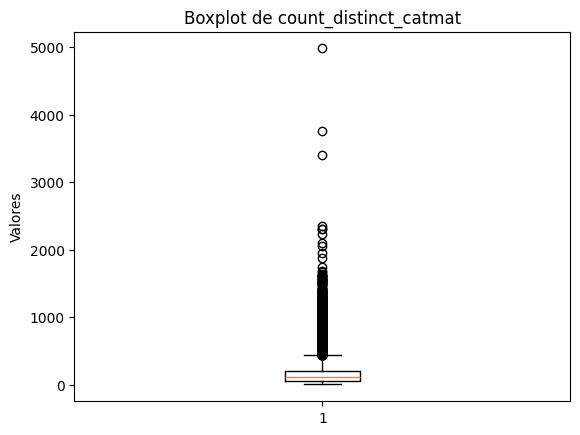

In [23]:
import matplotlib.pyplot as plt

# Obtenha a coluna de dados como uma lista
dados = df_cnes.select("count_distinct_catmat").rdd.flatMap(lambda x: x).collect()

plt.boxplot(dados)
plt.title('Boxplot de count_distinct_catmat')
plt.ylabel('Valores')
plt.show()

In [ ]:
import requests
import json
import os

# Criando a pasta se ela não existir
os.makedirs('../dados', exist_ok=True)

# Lista para armazenar os retornos da API
data_list = []

# Coletando todas as linhas do DataFrame como uma lista
rows = df_cnes.collect()

# Iterando sobre a lista de linhas
for row in rows:
    # Construindo a URL da API
    url = f'https://apidadosabertos.saude.gov.br/cnes/estabelecimentos/{row["co_cnes"]}'

    # Fazendo a requisição para a API
    response = requests.get(url)

    # Verificando se a requisição foi bem sucedida
    if response.status_code == 200:
        # Adicionando o retorno da API na lista
        data_list.append(response.json())
    else:
        print('Erro na requisição', response.status_code)

# Escrevendo a lista em um arquivo JSON
with open('../dados/estabelecimentos.json', 'w') as f:
    json.dump(data_list, f)

print(data_list)

In [10]:
# Configurações da conexão com o banco de dados
url = "jdbc:postgresql://localhost:5433/dbbnafar"
properties = {
    "user": "postgres",
    "password": "postgres",
    "driver": "org.postgresql.Driver"
}

# Escrevendo o DataFrame no banco de dados
df = df.fillna({'CO_CNES': 0})
df.write.jdbc(url=url, table="tb_estoque", mode="overwrite", properties=properties)

In [11]:
# Escrevendo o DataFrame no banco de dados
df_estabelecimentos = spark.read.json('../dados/estabelecimentos.json')
df_estabelecimentos.write.jdbc(url=url, table="tb_estabelecimentos", mode="overwrite", properties=properties)

23/12/12 11:39:51 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [12]:
df_estabelecimentos.printSchema()

root
 |-- bairro_estabelecimento: string (nullable = true)
 |-- codigo_atividade_ensino_unidade: string (nullable = true)
 |-- codigo_cep_estabelecimento: string (nullable = true)
 |-- codigo_cnes: long (nullable = true)
 |-- codigo_esfera_administrativa_unidade: string (nullable = true)
 |-- codigo_estabelecimento_saude: string (nullable = true)
 |-- codigo_identificador_turno_atendimento: string (nullable = true)
 |-- codigo_motivo_desabilitacao_estabelecimento: string (nullable = true)
 |-- codigo_municipio: long (nullable = true)
 |-- codigo_natureza_organizacao_unidade: string (nullable = true)
 |-- codigo_nivel_hierarquia_unidade: string (nullable = true)
 |-- codigo_tipo_unidade: long (nullable = true)
 |-- codigo_uf: long (nullable = true)
 |-- descricao_esfera_administrativa: string (nullable = true)
 |-- descricao_natureza_juridica_estabelecimento: string (nullable = true)
 |-- descricao_nivel_hierarquia: string (nullable = true)
 |-- descricao_turno_atendimento: string (null

In [15]:
# Definindo as colunas para remover
colunas_para_remover = [
"codigo_atividade_ensino_unidade",
"codigo_cnes"
"codigo_esfera_administrativa_unidade",
"codigo_estabelecimento_saude",
"codigo_identificador_turno_atendimento",
"codigo_motivo_desabilitacao_estabelecimento",
"codigo_municipio",
"codigo_natureza_organizacao_unidade",
"codigo_nivel_hierarquia_unidade",
"codigo_tipo_unidade",
"codigo_uf",
"descricao_esfera_administrativa",
"descricao_natureza_juridica_estabelecimento",
"descricao_nivel_hierarquia",
"descricao_turno_atendimento",
"estabelecimento_faz_atendimento_ambulatorial_sus",
"estabelecimento_possui_atendimento_ambulatorial",
"estabelecimento_possui_atendimento_hospitalar",
"estabelecimento_possui_centro_cirurgico",
"estabelecimento_possui_centro_neonatal",
"estabelecimento_possui_centro_obstetrico",
"estabelecimento_possui_servico_apoio",
"natureza_organizacao_entidade",
"tipo_gestao"]

# Removendo as colunas
df_estabelecimentos = df_estabelecimentos.drop(*colunas_para_remover)

# Renomeando colunas
df_estabelecimentos = df_estabelecimentos.withColumnRenamed("bairro_estabelecimento", "no_bairro")
df_estabelecimentos = df_estabelecimentos.withColumnRenamed("codigo_cep_estabelecimento", "co_cep")
df_estabelecimentos = df_estabelecimentos.withColumnRenamed("codigo_cnes", "co_cnes_estabelecimento")
df_estabelecimentos = df_estabelecimentos.withColumnRenamed("endereco_email_estabelecimento", "ds_email")
df_estabelecimentos = df_estabelecimentos.withColumnRenamed("endereco_estabelecimento", "ds_endereco")
df_estabelecimentos = df_estabelecimentos.withColumnRenamed("latitude_estabelecimento_decimo_grau", "latitude")
df_estabelecimentos = df_estabelecimentos.withColumnRenamed("longitude_estabelecimento_decimo_grau", "longitude")
df_estabelecimentos = df_estabelecimentos.withColumnRenamed("nome_fantasia", "no_estabelecimento")
df_estabelecimentos = df_estabelecimentos.withColumnRenamed("nome_razao_social", "no_razao_social")
df_estabelecimentos = df_estabelecimentos.withColumnRenamed("numero_cnpj", "nu_cnpj")
df_estabelecimentos = df_estabelecimentos.withColumnRenamed("numero_estabelecimento", "nu_estabelecimento")
df_estabelecimentos = df_estabelecimentos.withColumnRenamed("numero_telefone_estabelecimento", "nu_telefone")

# Fazendo o join
df_joined = df.join(df_estabelecimentos, df.CO_CNES == df_estabelecimentos.co_cnes_estabelecimento, 'left')

df_joined.printSchema()

root
 |-- CO_UF: string (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- CO_MUNICIPIO_IBGE: string (nullable = true)
 |-- NO_MUNICIPIO: string (nullable = true)
 |-- CO_CNES: string (nullable = false)
 |-- DT_POSICAO_ESTOQUE: timestamp (nullable = true)
 |-- CO_CATMAT: string (nullable = true)
 |-- DS_PRODUTO: string (nullable = true)
 |-- QT_ESTOQUE: string (nullable = true)
 |-- NU_LOTE: string (nullable = true)
 |-- DT_VALIDADE: string (nullable = true)
 |-- TP_PRODUTO: string (nullable = true)
 |-- SG_PROGRAMA_SAUDE: string (nullable = true)
 |-- DS_PROGRAMA_SAUDE: string (nullable = true)
 |-- SG_ORIGEM: string (nullable = true)
 |-- no_bairro: string (nullable = true)
 |-- co_cep: string (nullable = true)
 |-- co_cnes_estabelecimento: long (nullable = true)
 |-- codigo_esfera_administrativa_unidade: string (nullable = true)
 |-- ds_email: string (nullable = true)
 |-- ds_endereco: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (

In [19]:
from pyspark.sql.types import IntegerType

df_joined = df_joined.withColumn("QT_ESTOQUE", df_joined["QT_ESTOQUE"].cast(IntegerType()))

In [20]:
df_joined.printSchema()

root
 |-- CO_UF: string (nullable = true)
 |-- SG_UF: string (nullable = true)
 |-- CO_MUNICIPIO_IBGE: string (nullable = true)
 |-- NO_MUNICIPIO: string (nullable = true)
 |-- CO_CNES: string (nullable = false)
 |-- DT_POSICAO_ESTOQUE: timestamp (nullable = true)
 |-- CO_CATMAT: string (nullable = true)
 |-- DS_PRODUTO: string (nullable = true)
 |-- QT_ESTOQUE: integer (nullable = true)
 |-- NU_LOTE: string (nullable = true)
 |-- DT_VALIDADE: string (nullable = true)
 |-- TP_PRODUTO: string (nullable = true)
 |-- SG_PROGRAMA_SAUDE: string (nullable = true)
 |-- DS_PROGRAMA_SAUDE: string (nullable = true)
 |-- SG_ORIGEM: string (nullable = true)
 |-- no_bairro: string (nullable = true)
 |-- co_cep: string (nullable = true)
 |-- co_cnes_estabelecimento: long (nullable = true)
 |-- codigo_esfera_administrativa_unidade: string (nullable = true)
 |-- ds_email: string (nullable = true)
 |-- ds_endereco: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double 

In [21]:
df_joined.write.jdbc(url=url, table="tb_estoque_estabelecimentos", mode="overwrite", properties=properties)